In [ ]:
import sys,os,re
import pandas as pd 	#for CSV or large data files
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns	#for ploting or visual representation of data
from tqdm import tqdm
import string
import pickle

sys.path.append(r"D:\code\repo\M.tech\sem1\DA\LAB\contest")
from FILE_DIR import *

import joblib

# from sentence_transformers import SentenceTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, classification_report, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

import torch

tqdm.pandas()

<h3 style="color:orange">Hyperparameters</h3>

In [1]:
DEVICE="cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE=[8,16,32,64,128][1]

def text_preprocess(text):
    if not isinstance(text,str):
        return text
    
    text=text.lower()
    text.translate(str.maketrans('','',string.punctuation))
    text.translate(str.maketrans('','',"0123456789"))
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

print(BATCH_SIZE)
print(DEVICE)

NameError: name 'torch' is not defined

<h3 style="color:orange">Load Data</h3>

In [3]:
data=pd.read_json(TEST_DATA)

with open(FIX_MERTIC_DEF,"rb") as file:
    defination_emb=pickle.load(file)

# text preprocess
for col in ["user_prompt","response","system_prompt"]:
    data[col]=data[col].apply(text_preprocess)

print(data.shape)
print(len(defination_emb.values()))
# data

(3638, 4)
145


In [4]:
print(data.duplicated().sum())
# data.drop_duplicates(inplace=True)
# data.reset_index(drop=True,inplace=True)

print(data["metric_name"].isna().sum())
print(data["user_prompt"].isna().sum())
print(data["response"].isna().sum())
print(data["system_prompt"].isna().sum())

data[['user_prompt', 'response', 'system_prompt']] = data[['user_prompt', 'response', 'system_prompt']].fillna('')

14
0
0
1
1106


In [5]:
data["metric_embeddings"]=data["metric_name"].map(defination_emb)

<h3 style="color:orange">Load embbedings</h3>

In [6]:
response_emb=pd.read_parquet("./temp/embeddings/gemma_og/test/response.parquet")
system_prompt_emb=pd.read_parquet("./temp/embeddings/gemma_og/test/system_prompt.parquet")
user_prompt_emb=pd.read_parquet("./temp/embeddings/gemma_og/test/user_prompt.parquet")

data["response_emb"]=response_emb
data["system_prompt_emb"]=system_prompt_emb
data["user_prompt_emb"]=user_prompt_emb

# data

<h3 style="color:orange">add cosine similarity</h3>

In [7]:
# def cos_sim(C1,C2):
#     return cosine_similarity(C1.reshape(-1,1),C2.reshape(-1,1)) 

# data["cos_ur"] = data.progress_apply(lambda row: cos_sim(row["response_emb"],row["user_prompt_emb"]),axis=1)
# data["cos_rs"] = data.progress_apply(lambda row: cos_sim(row["response_emb"],row["system_prompt_emb"]),axis=1)
# data["cos_us"] = data.progress_apply(lambda row: cos_sim(row["system_prompt_emb"],row["user_prompt_emb"]),axis=1)

# print(f"ur: {np.mean(data['cos_ur'].values)}")
# print(f"us: {np.mean(data['cos_us'].values)}")
# print(f"rs: {np.mean(data['cos_rs'].values)}")

In [8]:
# ALPHA,BETA=[(1,1),(0.4,0.6)][0]

# def combine_features(m, t,alpha=ALPHA,beta=BETA):
#     return np.concatenate([
#         alpha*m,                  # metric embedding
#         beta*t,                  # text embedding
#         np.abs(m - t),      # absolute difference
#         m * t               # elementwise product
#     ])

# data['combined_vector'] = [combine_features(m, t,ALPHA,BETA) for m, t in zip(data['metric_embeddings'], data['text_embedding'])]

<h3 style="color:orange">creating feature data</h3>

In [10]:
##stacking
x= np.hstack([
    np.vstack(data["metric_embeddings"].values),
    np.vstack(data["response_emb"].values),
    np.vstack(data["system_prompt_emb"].values),
    np.vstack(data["user_prompt_emb"].values),
    # np.vstack(data["cos_ur"].values),
    # np.vstack(data["cos_us"].values),
    # np.vstack(data["cos_rs"].values)
])

## averaging embding
# x=avg_emb

<h5 style="color:cyan">Standardize</h5>

In [11]:
st=StandardScaler()
x=st.fit_transform(x)

<h3 style="color:orange">load model</h3>

In [ ]:
model_name=["LinearRegression","Ridge","XGBRegressor","XGBRFRegressor","RandomForestRegressor","MLPRegressor"][-1]
model=joblib.load(f"{MODEL_DIR}/{model_name}.pkl")

y_pred=model.predict(x)

print(y_pred)
y_pred_rounded = np.clip(np.round(y_pred), 0, 10)
# y_pred_rounded =y_pred
print(y_pred_rounded)

[6.3893266 9.561926  8.368154  ... 7.1265063 7.650967  8.460243 ]
[ 6. 10.  8. ...  7.  8.  8.]


In [ ]:
ans=pd.DataFrame(list(zip((range(1,len(y_pred_rounded)+1)),y_pred_rounded)),columns=["ID","score"])

ans.to_csv(f"{OUTPUT_SCORE}\\answer_{model_name}.csv",index=False)

In [14]:
ans["score"].value_counts()

score
7.0     1104
6.0      987
8.0      685
5.0      369
9.0      262
4.0      105
3.0       53
10.0      35
2.0       28
1.0        8
0.0        2
Name: count, dtype: int64

<h3 style="color:orange">check output w.r.t best one</h3>

In [17]:
best_ans=pd.read_csv("{OUTPUT_SCORE}\answer_best(3.654)_MLPRegressor.csv")
best_ans["score"].value_counts()

score
7.0     1104
6.0      987
8.0      685
5.0      369
9.0      262
4.0      105
3.0       53
10.0      35
2.0       28
1.0        8
0.0        2
Name: count, dtype: int64

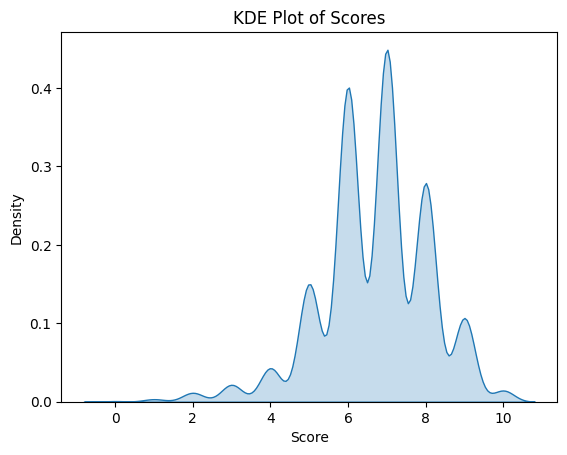

In [18]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.kdeplot(data=best_ans, x="score", fill=True)
plt.title("KDE Plot of Scores")
plt.xlabel("Score")
plt.ylabel("Density")
plt.show()


<h3 style="color:orange">check current model</h3>